In [1]:
cd /content/drive/MyDrive/Colab Notebooks/VAE

/content/drive/MyDrive/Colab Notebooks/VAE


In [2]:
filename = ''

In [3]:
pip install tensorboardX

     |████████████████████████████████| 317kB 11.1MB/s 


In [4]:
import torch
from torch import nn, optim  
from torch.nn import functional as F
import pandas as pd
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import Logger
from IPython import display

In [5]:
DATA_FOLDER = 'cifar_10'
#,torchvision.transforms.Normalize([.5, .5, .5], [.5, .5, .5])
def cifar_data(): 
  compose = torchvision.transforms.Compose( [ torchvision.transforms.ToTensor()] ) 
  out_dir = '{}/dataset'.format(DATA_FOLDER) 
  return torchvision.datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True) 
 
train_dataset = cifar_data()

Files already downloaded and verified


In [6]:
img_size = 32
num_chanels = 3
n_features = img_size*img_size*num_chanels
distrib_features = 64
kernel_num = 128

In [7]:
logger = Logger(model_name='VAE_DC', data_name='CIFAR')

In [8]:
class DCVAutoEncoder(nn.Module):
  def __init__(self):
    super(DCVAutoEncoder, self).__init__() 
    self.encoder = nn.Sequential(   
        nn.Conv2d(3, kernel_num, 3, 1),
        nn.BatchNorm2d(kernel_num),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),
 
        nn.Conv2d(kernel_num, kernel_num // 2, 3, 2),
        nn.BatchNorm2d(kernel_num // 2),
        nn.LeakyReLU(0.2), 
 
        nn.Conv2d(kernel_num // 2, kernel_num // 4, 3, 2), 
        nn.LeakyReLU(0.2), 
        nn.Flatten(),
    
        nn.Linear(288, distrib_features*2), 
        nn.LeakyReLU(0.2) 
        #nn.ReLU(),
    )
 
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(3, kernel_num // 8, 3, 1),
        nn.BatchNorm2d(kernel_num // 8),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),
         
        nn.ConvTranspose2d(kernel_num // 8, kernel_num // 4, 3, 1),
        nn.BatchNorm2d(kernel_num // 4),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2), 
 
        nn.ConvTranspose2d(kernel_num // 4, kernel_num // 2, 3, 2), 
        nn.Dropout(0.2),
        nn.LeakyReLU(0.2), 
        nn.Flatten(),
 
 
        nn.Linear(in_features=23104, out_features=4096),  
        nn.LeakyReLU(0.2),
        nn.Linear(in_features=4096, out_features=n_features),  
        nn.Sigmoid()
    )
    
    # Network to learn mu
    self.mu_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        nn.ReLU()
    )
    
    project_size = img_size * img_size * 3
 
    # Network to learn log_var
    self.logvar_network = nn.Sequential(
        nn.Linear(in_features=distrib_features*2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=distrib_features),
        nn.ReLU()
    )
 
    self.project = nn.Sequential(
        nn.Linear(in_features=distrib_features, out_features=n_features),
        nn.ReLU()
    )
  
  def reparametization(self, mean, log_var):
    std = torch.exp(log_var/2)  # the standard deviation
    eps = torch.randn_like(std) # sample epsilone from N(0,1) with the same size as std
    z = mean + (eps * std) # Sample example similar to the input space
    return z  
 
  def forward(self, x): 
    x = vector_to_image(x) # Reshape 
    # Encode the input
    x = self.encoder(x) 
 
    # learn mu and log var within different networks
    mu = self.mu_network(x) 
    l_var = self.logvar_network(x) 
    z = self.reparametization(mu, l_var) # Reparametrization trick
    
    x = self.project(z)
    #print('X size', x.size(), x.view(-1, 3, 28, 28).size())
 
    x = self.decoder(x.view(-1, num_chanels, img_size, img_size))  
    return x, mu, l_var # return all learned parameters

In [9]:
def vector_to_image(vectors):
  return vectors.view(vectors.size(0), num_chanels, img_size, img_size)
 
def image_to_vector(image):
  return image.view(image.size(0), n_features)

In [10]:
has_gpu = torch.cuda.is_available() 
 
autoencoder = DCVAutoEncoder()

In [11]:
if has_gpu:
  autoencoder = autoencoder.cuda()
else:
  autoencoder = autoencoder
 
print(autoencoder)

DCVAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (8): LeakyReLU(negative_slope=0.2)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=288, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2

In [ ]:
#autoencoder.load_state_dict(torch.load("./data/models/VAE_DC/CIFAR/D_epoch_199"))

In [12]:
input = torch.randn(384, 2352)#.cuda()

#print(vector_to_image(input).size())
m = nn.Sequential(  
        nn.ConvTranspose2d(3, kernel_num // 8, 3, 1),
        nn.BatchNorm2d(kernel_num // 8),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2),
         
        nn.ConvTranspose2d(kernel_num // 8, kernel_num // 4, 3, 1),
        nn.BatchNorm2d(kernel_num // 4),
        nn.LeakyReLU(0.2),
        nn.MaxPool2d(2), 

        nn.ConvTranspose2d(kernel_num // 4, kernel_num // 2, 3, 2), 
        nn.Dropout(0.2),
        nn.LeakyReLU(0.2), 
        nn.Flatten()
)
print(autoencoder.decoder) 
#output = m(input.view(-1, 3, 28, 28))
if has_gpu: input = input.view(-1, num_chanels, img_size, img_size).cuda()
else:
  input = input.view(-1, num_chanels, img_size, img_size)
output = m(input.data.cpu())
print(output.size()) 
output = autoencoder.decoder(input)
print(output.size()) 

Sequential(
  (0): ConvTranspose2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (9): Dropout(p=0.2, inplace=False)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=23104, out_features=4096, bias=True)
  (13): LeakyReLU(negative_slope=0.2)
  (14): Linear(in_features=4096, out_features=3072, bias=True)
  (15): Sigmoid()
)
torch.Size([294, 23104])
torch.Size([294, 3072])


In [13]:
def vea_loss(bce_loss, mean, log_var):
  # sum bce loss and the KL divergence
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return bce_loss + KLD

In [14]:
ae_optim = optim.Adam(autoencoder.parameters(), lr=0.0005)

# loss function
loss = nn.BCELoss(reduction='sum')

# Number of epochs
num_epochs = 200

# batch size
batch_size = 100

In [15]:
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

num_batches=len(data_loader)

In [ ]:
for epoch in range(num_epochs): # loop over dataset
    loss_log = 0  
    for n_batch, (train_data, _) in enumerate(data_loader):  
 
        train_data  = Variable(image_to_vector(train_data)) 

        if has_gpu: train_data = train_data.cuda()

        # reset the gradients back to zero
        ae_optim.zero_grad()

        # compute reconstruction  
        reconstructed, mu, log_var = autoencoder(train_data) 

        # compute the loss 
        bce_loss = loss(reconstructed, train_data)  

        train_loss = vea_loss(bce_loss, mu, log_var)

        loss_log += train_loss.item()
        # backpropagate the gradient 
        train_loss.backward()

        # update parameter update based on current gradients
        ae_optim.step()
        
    
        # Log the image
        if(n_batch) % 500 == 0:
            display.clear_output(True)
            logger.log_images(images = vector_to_image(reconstructed[0:16]).data.cpu(), num_images = 16, epoch=epoch, n_batch = n_batch,  num_batches=num_batches)
            logger.display_ea_status(
                epoch, num_epochs, n_batch, num_batches,
                loss_log
            ) 
            #logger.save_model(autoencoder, epoch)
    # epoch loss 
    loss_log = loss_log / len(data_loader.dataset)
    if (epoch % 50 == 0) or epoch== 199:
      logger.save_model(autoencoder, epoch)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss_log))

In [92]:
def plot_images(model,
                image,
                show=True,
                step=0,
                model_name="auto_encoder"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        model (Models): 
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """

    constructed, _, _ = model(image)
    #constructed = model(image)
    if isinstance(image, torch.autograd.Variable):
      image = image.cpu().detach().numpy() 
      #image = np.transpose(image, (1,2,0))
    else:
      image = image

    if isinstance(constructed, torch.autograd.Variable): 
      images = vector_to_image(constructed)
      images = images.cpu().detach().numpy()  
    else:
      images = np.reshape(constructed, [img_size, img_size, 3])
    print(model_name,
          "Labels for generated images: ")
    print("image size", images.shape)
    plt.figure(figsize=(12, 12)) 
    num_images = images.shape[0] 
    
    rows =  int(np.sqrt(num_images))*2  #int(math.sqrt(noise_class.shape[0]))
    print("ROWS", rows)
    for i in range(num_images): 
        plt.subplot(rows, rows, i + 1)
        img2 = np.transpose(image[i], (1,2,0))  #np.reshape(image[i], [img_size, img_size, 3]) 
        plt.imshow(img2, cmap='gray')
        plt.axis('off')

        plt.subplot(rows, rows, num_images + i + 1) 
        img = np.transpose(images[i], (1,2,0)) #np.reshape(images[i], [img_size, img_size, 3])  
        plt.imshow(img, cmap='gray') 
        plt.axis('off')
    save_images(plt)
    if show:
        plt.show()
    else:
        plt.close('all')

In [83]:
data_subdir = 'cifar'
def make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
          print(e)
        #    if e.errno != errno.EEXIST:
        #       raise

def save_images(fig, epoch=0, n_batch=0, comment=''):
        out_dir = './data/images/{}'.format(data_subdir)
        make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir, comment, epoch, n_batch))

In [18]:
autoencoder.load_state_dict(torch.load("./data/models/VAE_DC/CIFAR/D_epoch_199"))

<All keys matched successfully>

torch.Size([16, 3, 32, 32])
auto_encoder Labels for generated images: 
image size (16, 3, 32, 32)
ROWS 8
[Errno 17] File exists: './data/images/cifar'


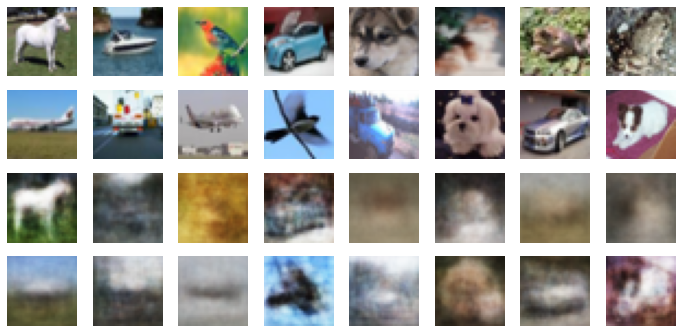

In [114]:
#img = Variable(train_data[0:16]) 
original_data = []
for i in data_loader:
  original_data, label = i
  break 

#print(image_to_vector(original_data))

img = Variable(original_data[0:16])
print(img.shape)
#img = img.contiguous()
#img = img.view(-1, n_features)

#img = torch.rand_like(img)
if has_gpu: img = img.cuda()
#img = image_to_vector(img) 
#img = autoencoder.project(torch.randn(16, 64).cuda()) 
#img = vector_to_image(img)

plot_images(autoencoder, img)